In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn.utils import prune
from torch.amp import autocast, GradScaler

import torchvision
from torchvision.datasets import ImageNet, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms._presets import ImageClassification

from pathlib import Path
from tqdm.notebook import tqdm
from einops import einsum, rearrange, reduce
from typing import Union, Tuple, Any, Generator



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [4]:
model = resnet18(weights=weights)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
for layer_i, param in enumerate(model.parameters()):
    print('Layer', layer_i, 'shape: \n', param.shape,  '\n')

Layer 0 shape: 
 torch.Size([64, 3, 7, 7]) 

Layer 1 shape: 
 torch.Size([64]) 

Layer 2 shape: 
 torch.Size([64]) 

Layer 3 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 4 shape: 
 torch.Size([64]) 

Layer 5 shape: 
 torch.Size([64]) 

Layer 6 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 7 shape: 
 torch.Size([64]) 

Layer 8 shape: 
 torch.Size([64]) 

Layer 9 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 10 shape: 
 torch.Size([64]) 

Layer 11 shape: 
 torch.Size([64]) 

Layer 12 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 13 shape: 
 torch.Size([64]) 

Layer 14 shape: 
 torch.Size([64]) 

Layer 15 shape: 
 torch.Size([128, 64, 3, 3]) 

Layer 16 shape: 
 torch.Size([128]) 

Layer 17 shape: 
 torch.Size([128]) 

Layer 18 shape: 
 torch.Size([128, 128, 3, 3]) 

Layer 19 shape: 
 torch.Size([128]) 

Layer 20 shape: 
 torch.Size([128]) 

Layer 21 shape: 
 torch.Size([128, 64, 1, 1]) 

Layer 22 shape: 
 torch.Size([128]) 

Layer 23 shape: 
 torch.Size([128]) 

Layer 24 shape: 
 torch.Size([128

In [6]:
BATCH_SIZE = 1024

try:
    from google.colab import drive
    drive.mount('/content/drive')
    datapath = Path().cwd() / 'drive' / 'MyDrive' / 'data'
except:
    datapath = Path().cwd() / 'data'
finally:
    print(f'Data from {datapath}')

cifar10 = CIFAR10(
    root=datapath,
    train=False,
    transform=transforms,
    download=True
)

cifar10_test = CIFAR10(
    root=datapath,
    train=False,
    transform=transforms,
    download=True
)

dataloader = torch.utils.data.DataLoader(
    cifar10,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Mounted at /content/drive
Data from /content/drive/MyDrive/data


In [7]:
label_mapping = dict(enumerate(cifar10.classes))
label_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
def visualize_normalized_image(image: torch.Tensor,
                               transform: ImageClassification,
                               batch_size: int) -> None:
    """
    Combines a batch of images into 1 and plots them.
    """
    assert isinstance(image, torch.Tensor), f'image type is {type(image)}'
    assert batch_size % 2 == 0, f'uneven {batch_size}'

    image = image.numpy()
    std, mean = transform.std, transform.mean
    std, mean = np.array(std), np.array(mean)

    b1, b2 = batch_size//8, 8
    image = einsum(image, std, 'b c h w, c -> b h w c') + mean
    image = rearrange(image, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=b1, b2=b2)
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('Shape: ', image.shape)

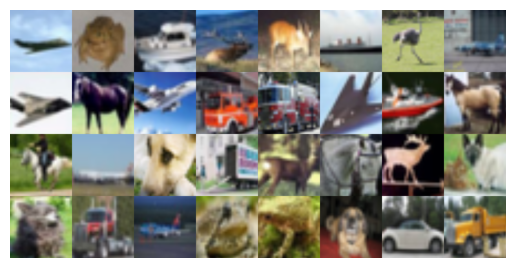

Shape:  (896, 1792, 3)


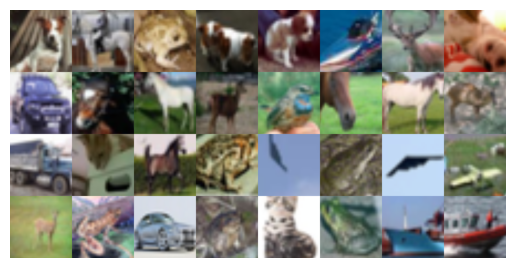

Shape:  (896, 1792, 3)


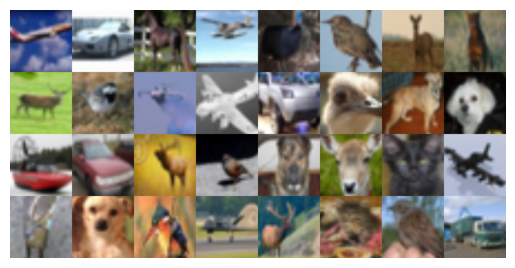

Shape:  (896, 1792, 3)


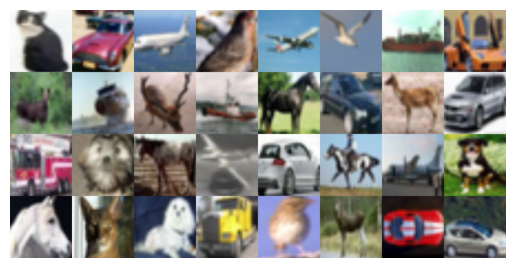

Shape:  (896, 1792, 3)


In [14]:
# n_of_batch_images_to_show = 4
# current_label = None

# for i, (image, label) in enumerate(dataloader):
#     label0 = int(label[0])

#     if label0 != current_label:
#         visualize_normalized_image(image, transforms, 32)
#         n_of_batch_images_to_show -= 1
#         current_label = label0

#     if n_of_batch_images_to_show == 0:
#         break


Initial CIFAR10 Prediction without any

In [9]:
def evaluate_model(model, dataloader, stop_at=None):
    model = model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    i = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            i += 1
            if stop_at:
                if i >= stop_at:
                    break

        accuracy = total_correct / total_samples

    return total_correct, total_samples, accuracy

In [45]:
total_correct, total_samples, accuracy = evaluate_model(model, dataloader_test)

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
print(f'Total Correct: {total_correct}\n')
print(f'Total Samples: {total_samples}\n')
print(f'Accuraccy: {accuracy}\n')

Total Correct: 2

Total Samples: 10000

Accuraccy: 0.0002



# Model Modification

In [10]:
model_fc_in = model.fc.in_features
model_fc_out = len(label_mapping)

model.fc = nn.Linear(model_fc_in, model_fc_out)

In [11]:
for param in model.parameters():
    param.requires_grad = False

In [12]:
for param in model.fc.parameters():
    param.requires_grad = True

In [50]:
total_correct, total_samples, accuracy = evaluate_model(model, dataloader_test)

  0%|          | 0/10 [00:00<?, ?it/s]

In [51]:
print(f'Total Correct: {total_correct}\n')
print(f'Total Samples: {total_samples}\n')
print(f'Accuraccy: {accuracy}\n')

Total Correct: 869

Total Samples: 10000

Accuraccy: 0.0869



In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
# scaler = GradScaler('cuda')

In [14]:
def train_model(model, dataloader, loss, optimizer, num_epochs=10):
    model = model.to(device)
    model.train()

    for epoch in tqdm(range(num_epochs)):
        total_loss = 0

        for images, labels in tqdm(dataloader):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)

            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch: {epoch + 1}, loss = {avg_loss:.4f}')


In [15]:
train_model(model, dataloader, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, loss = 2.5722


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2, loss = 1.3137


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3, loss = 0.9588


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4, loss = 0.8175


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5, loss = 0.7460


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6, loss = 0.7166


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7, loss = 0.6831


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8, loss = 0.6650


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9, loss = 0.6503


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, loss = 0.6402


In [16]:
evaluate_model(model, dataloader_test)

  0%|          | 0/10 [00:00<?, ?it/s]

(7909, 10000, 0.7909)

In [17]:
prune.random_unstructured(model.fc, name='weight', amount=0.3)
# prune.remove(model.fc, "weight")

Linear(in_features=512, out_features=10, bias=True)

In [18]:
train_model(model, dataloader, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, loss = 0.8062


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2, loss = 0.7352


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3, loss = 0.6990


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4, loss = 0.6812


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5, loss = 0.6640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6, loss = 0.6583


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7, loss = 0.6432


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8, loss = 0.6310


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9, loss = 0.6225


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, loss = 0.6180


In [19]:
evaluate_model(model, dataloader_test)

  0%|          | 0/10 [00:00<?, ?it/s]

(7959, 10000, 0.7959)

In [20]:
prune.random_unstructured(model.fc, name='weight', amount=0.3)

Linear(in_features=512, out_features=10, bias=True)

In [21]:
train_model(model, dataloader, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, loss = 0.8128


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2, loss = 0.7515


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3, loss = 0.7202


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4, loss = 0.6999


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5, loss = 0.6920


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6, loss = 0.6795


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7, loss = 0.6667


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8, loss = 0.6647


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9, loss = 0.6604


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, loss = 0.6523


In [22]:
evaluate_model(model, dataloader_test)

  0%|          | 0/10 [00:00<?, ?it/s]

(7776, 10000, 0.7776)

In [24]:
model.fc.weight_mask.sum()

tensor(2509., device='cuda:0')